In [1]:
#########################(Academic purpose)####################################
#MAP-PDMA (2021/22) - PhD program in Applied Mathematics (UM | UA | UP)

#Author: Carlos Fernando Arraz
#Subject: Generalized matrix inverse theory | Moore–Penrose inverse application
#Date: 2022-06
#Version.: 01
#File: Procrustes_face_recognition_V01.ipynb
#########################(Academic purpose)####################################

##A practical Moore–Penrose inverse application: This coding was made to attend requisites of the MAP-PDMA (2nd. semester) course. The application and theory were based on the article [1], and all coding scripts reflect my vision regarding this theme:

**The main aim is to show, in a simple way, a direct application of the Penrose inverse matrix for face recognition. For the training and testing of the model, the ORL dataset (https://cam-orl.co.uk/facedatabase.html) has been chosen, where is possible to access more than 400 pictures of 42 different persons.**

**References:** \\
[1] Sujith, K. R., & Ramanan, G. V. (2005, October). Procrustes analysis and moore-penrose inverse based classifiers for face recognition. In International Workshop on Biometric Person Authentication (pp. 59-66). Springer, Berlin, Heidelberg.

[2] Hurley, J. R., and Cattell, R. B. (1962). The procrustes program: Producing direct rotation to test a hypothesized factor structure.

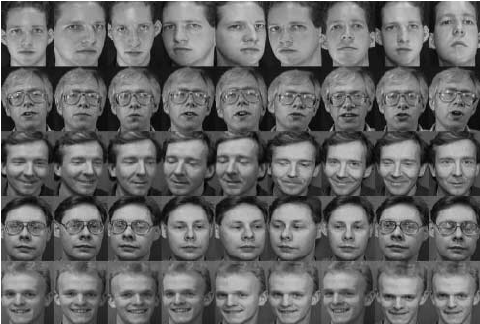

## Context: Procrustes analysis

Where does the problem get its name?

The problem gets its name from Hurley and Cattell (1962) (Reference [2]). Quoting directly from the paper:

"...It will be recalled that the Greek hero Theseus encountered in his wanderings a character called Procrustes, whose beds fitted all travelers. Those who were too short for his beds he cruelly stretched and those who were too tall he cut down to size..."

The idea from here is, given two matrices $A, B$, how is possible to search out a transformation $X$ (to stretch or  to cut depending on the case) such that

$$
A - BX \approx 0.
$$

##Pre-processing images and preparing for modeling theory section and application of functions.


In [2]:
#To load python libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from scipy.spatial import distance
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [3]:
# To extract the data from the ZIP file

#OLR dataset
# archive_name = "/content/ORL.zip"
!unzip '/content/ORL' -d '/content/ORL/'

Archive:  /content/ORL.zip
replace /content/ORL/ORL/100_10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/ORL/ORL/100_10.jpg  
  inflating: /content/ORL/ORL/101_11.jpg  
  inflating: /content/ORL/ORL/102_11.jpg  
  inflating: /content/ORL/ORL/103_11.jpg  
  inflating: /content/ORL/ORL/104_11.jpg  
  inflating: /content/ORL/ORL/105_11.jpg  
  inflating: /content/ORL/ORL/106_11.jpg  
  inflating: /content/ORL/ORL/107_11.jpg  
  inflating: /content/ORL/ORL/108_11.jpg  
  inflating: /content/ORL/ORL/109_11.jpg  
  inflating: /content/ORL/ORL/10_1.jpg  
  inflating: /content/ORL/ORL/110_11.jpg  
  inflating: /content/ORL/ORL/111_12.jpg  
  inflating: /content/ORL/ORL/112_12.jpg  
  inflating: /content/ORL/ORL/113_12.jpg  
  inflating: /content/ORL/ORL/114_12.jpg  
  inflating: /content/ORL/ORL/115_12.jpg  
  inflating: /content/ORL/ORL/116_12.jpg  
  inflating: /content/ORL/ORL/117_12.jpg  
  inflating: /content/ORL/ORL/118_12.jpg  
  inflating: /content/ORL/ORL/119_12.j

In [4]:
# To define the path of photos (faces)
#ORL dataset on google colab folder
path = "/content/ORL/"

In [5]:
#Function to map folder and output list with all files
def files_in_folder(path):
  """
  input
  path: (str) with path of folder

  output
  files: (list) with path of each file (e.g.,'/content/ORL/999_9.jpg') into folder
  """
  files = []
  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
          # print(os.path.join(dirname, filename))
          files.append(os.path.join(dirname, filename))
  return files

In [6]:
# To check and to see file format, filename ans separators
files = files_in_folder(path); files

['/content/ORL/ORL/282_29.jpg',
 '/content/ORL/ORL/302_31.jpg',
 '/content/ORL/ORL/249_25.jpg',
 '/content/ORL/ORL/18_2.jpg',
 '/content/ORL/ORL/124_13.jpg',
 '/content/ORL/ORL/146_15.jpg',
 '/content/ORL/ORL/209_21.jpg',
 '/content/ORL/ORL/194_20.jpg',
 '/content/ORL/ORL/324_33.jpg',
 '/content/ORL/ORL/155_16.jpg',
 '/content/ORL/ORL/243_25.jpg',
 '/content/ORL/ORL/262_27.jpg',
 '/content/ORL/ORL/236_24.jpg',
 '/content/ORL/ORL/182_19.jpg',
 '/content/ORL/ORL/53_6.jpg',
 '/content/ORL/ORL/93_10.jpg',
 '/content/ORL/ORL/121_13.jpg',
 '/content/ORL/ORL/16_2.jpg',
 '/content/ORL/ORL/148_15.jpg',
 '/content/ORL/ORL/224_23.jpg',
 '/content/ORL/ORL/501_42.jpeg',
 '/content/ORL/ORL/192_20.jpg',
 '/content/ORL/ORL/181_19.jpg',
 '/content/ORL/ORL/52_6.jpg',
 '/content/ORL/ORL/130_13.jpg',
 '/content/ORL/ORL/95_10.jpg',
 '/content/ORL/ORL/84_9.jpg',
 '/content/ORL/ORL/234_24.jpg',
 '/content/ORL/ORL/270_27.jpg',
 '/content/ORL/ORL/1_1.jpg',
 '/content/ORL/ORL/69_7.jpg',
 '/content/ORL/ORL/162_1

In [7]:
#Test split for testing in foward function: to see how is possible to get the class among faces
'ORL/96_10.jpg'.split('/')[-1].split('_')[1]

'10.jpg'

In [8]:
#To read and preprocessing imagens into array
def readimages (list):
    """
    input
    list: (list) with all files and respective path

    output
    X: (np.array) array with all photos
    size: (num) with lenght of vector
    """
    # Read images 80 x 70 dimensions
    # imgs = glob.glob(path+'/*.'+extension)
    imgs = list
    # To read files in 0-255 gray scale and 2 channel
    base = [Image.open(i).convert('L') for i in imgs]

    # dataset size
    size = len(base)

    # To put images into array, where each row is set of pixels of each photo
    X = np.array([base[i].getdata() for i in range(size)])
    return X, size

In [9]:
#digits dataset
# from sklearn.datasets import load_digits
# digits = load_digits()
# print(digits.data.shape)

In [10]:
#To run function readimages (Test)
X, _ = readimages(files); X

#digits dataset

# digits = load_digits()
# files = digits.data
# size = digits.data.shape[0]
# X = np.array([files[i].flatten() for i in range(size)])

array([[ 75,  90,  83, ...,  42,  47,  37],
       [ 27,  31,  30, ..., 130, 191, 117],
       [ 90, 112, 106, ...,  79,  83,  70],
       ...,
       [214, 214, 214, ..., 123, 122, 121],
       [ 94, 111, 100, ...,  64,  70,  56],
       [200, 202, 203, ..., 179, 177, 172]])

In [11]:
#To check dimensions of vector
X.shape

(420, 5600)

In [12]:
#To define class column with all labels in each face
#OLR
y = [ i.split('_')[-1].split('.')[0] for i in files ];len(y)

#Datadigits
# y = digits.target


420

In [13]:
# y = list(map(lambda y: str(y), y))

In [14]:
#To put vector into dataframe as integer
df = pd.DataFrame(X, dtype='int'); df

0     1     2     3     4     5     6     7     8     9     ...  5590  \
0      75    90    83    86    84    86    85    83    84    88  ...    41   
1      27    31    30    32    31    28    32    31    33    30  ...   114   
2      90   112   106   107   105   106   105   107   108   105  ...    54   
3      25    33    30    31    33    30    33    33    31    32  ...   159   
4      81    92    86    92    87    91    93    88    93    90  ...   145   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
415    33    50    43    39    47    44    43    50    48    47  ...    39   
416    18    25    21    22    24    21    23    23    24    21  ...    81   
417   214   214   214   214   214   214   214   214   214   214  ...   105   
418    94   111   100   105   109   107   100   101    98   101  ...    58   
419   200   202   203   205   205   208   211   208   209   209  ...   138   

     5591  5592  5593  5594  5595  5596  5597  5598  5599  
0      43    44    41    45    45    44    42    47    37  
1     121    99    97   132   146   107   130   191   117  
2      83    90    83    72    55    82    79    83    70  
3     149   128   119   121   121   122   121   127   115  
4     137   124    60    10    13    17    16    26    27  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
415    60    90    87    51    55    66    67    82    75  
416    96   107   124   136   147   157   153   165   137  
417   103    98   103   102   109   120   123   122   121  
418    62    62    63    63    66    65    64    70    56  
419   134   126   134   152   174   180   179   177   172  

[420 rows x 5600 columns]

In [15]:
#To put into Class column all y values as part of dataframe df
df['Class'] = y; df

0    1    2    3    4    5    6    7    8    9  ...  5591  5592  5593  \
0     75   90   83   86   84   86   85   83   84   88  ...    43    44    41   
1     27   31   30   32   31   28   32   31   33   30  ...   121    99    97   
2     90  112  106  107  105  106  105  107  108  105  ...    83    90    83   
3     25   33   30   31   33   30   33   33   31   32  ...   149   128   119   
4     81   92   86   92   87   91   93   88   93   90  ...   137   124    60   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
415   33   50   43   39   47   44   43   50   48   47  ...    60    90    87   
416   18   25   21   22   24   21   23   23   24   21  ...    96   107   124   
417  214  214  214  214  214  214  214  214  214  214  ...   103    98   103   
418   94  111  100  105  109  107  100  101   98  101  ...    62    62    63   
419  200  202  203  205  205  208  211  208  209  209  ...   134   126   134   

     5594  5595  5596  5597  5598  5599  Class  
0      45    45    44    42    47    37     29  
1     132   146   107   130   191   117     31  
2      72    55    82    79    83    70     25  
3     121   121   122   121   127   115      2  
4      10    13    17    16    26    27     13  
..    ...   ...   ...   ...   ...   ...    ...  
415    51    55    66    67    82    75     28  
416   136   147   157   153   165   137     34  
417   102   109   120   123   122   121     41  
418    63    66    65    64    70    56     28  
419   152   174   180   179   177   172     42  

[420 rows x 5601 columns]

##Procrutes modeling (see reference [1])
###Formulation of the Problem
Let $n$ and $p$ be the number and dimension of feature vectors, respectively. Let $D$ be a $n \times p$ matrix with the feature vectors as its rows. We aim to find a transformed (sub)space where the feature vectors can be identified “correctly”.

Let

$$
B − DQ = \hat ϵ, (1)
$$

where $B$ is a $n \times n$ matrix with the transformed vectors as its rows, $Q$, a $p × n$ matrix, is the unknown transformation to be computed and $\hat ϵ$ is the criterion to be minimized. In the case of a labelled training set, we identify the matrix $B$ in equation (1) with the matrix whose rows and columns are indexed by the feature
vectors and the $(i, j)^{th}$  entry is 0 if the $i^{th}$ and the $j^{th}$ feature vectors belong to the same class and 1 if they belong to different classes. In the context of face recognition, $n$ and $p$ are the number of input face images and the number of pixels  respectively, and $D$ is the $n × p$ matrix whose rows are the input face images.

The criterion in equation (1) can be minimized in many ways. Conforme the article [1], the contribution to the face recognition problem is to formulate it in a manner that allows the application of Procrustes analysis and the Moore-Penrose inverse to minimize the error in equation (1) in two different ways (here, we studied just one of them: The Moore-Penrose Classifier).

We rewrite equation (1) in the form

$$
||B − DQ|| = ϵ, (2)
$$

where $ϵ$ is the criterion function to be minimized. Given the matrices $D$ and $B$, our objective is to find a transformation matrix $Q$, which minimizes the error $ϵ$ in equation (2).

#The Moore-Penrose Classifier
The objective of finding a transformation matrix $Q$ in equation (2) can also be achieved using the generalized inverse (Moore-Penrose Inverse) in the following manner. Let the singular value decomposition of $D$ be $U Σ V^T$ , where $Σ$ is the
$n \times p$ diagonal matrix with entries $ σ_1 ,\cdots ,σ_n$ which are the singular values of $D$.

The generalized inverse of $D$ is

$$
D^† = V Σ^† U^T , (3)
$$

where $Σ^†$ is the $p × n$ diagonal matrix with entries $\frac{1}{σ_1},\cdots, \frac{1}{σ_n}$. We premultiply equation (1) with $D^†$ and get

$$
D^†B = D^† DQ = D^†ϵ
$$


When the error term is neglected, the transformation matrix becomes,

$$
Q = D^†B
$$

This technique gives minimum error when the number of feature vectors in the training set is less than the dimension of the  feature vectors, as in the case of most face data sets. We call the classifier based on the above transformation the Moore-Penrose classifier (See reference [1]).

After achieving $Q$, is easy for any new sample to check a face (with $(1, p)$ dimension) unless of the training set, and to verify among all which one has the minimum distance as criterium for face recognition.

In [16]:
#Function for calculating inverse penrose and contructing the procruste problem
# B - DQ = epsilon => if epsilo = 0, then B = DQ => D'.B = Q is solution problem
def procrustes(X, path):
    """
    input
    X: (dataframe) with array of images
    path: (list) with names of files

    output
    np.dot(np.linalg.pinv(X), B): (numeric matrix) wiht moore-penrose inverse
    B: (numeric matrix) with 0's and 1's by procrutes problem modeling
    """
    #To create ones matrix
    B = np.ones([X.shape[0], X.shape[0]])
    lines = path
    cols  = path
    lin = 0
    # To search whole matrix row by row
    for i in lines:
        col = 0
        for j in cols:
            #OLR test without labels
            if i.split('_')[-1].split('.')[0] == j.split('_')[-1].split('.')[0]:
              B[lin, col] = 0
            #To add +1 for covering all columns into matrix
            col = col + 1
        lin = lin + 1
    # To compute the Moore-Penrose matrix (PAY ATTENTION IN THIS PART) for achieving Q.
    return np.dot(np.linalg.pinv(X), B), B

##To check if functions works and to see some outputs before forwarding to next step

In [17]:
#To check train/test/indices set
X_Train, X_Test, y_Train, y_Test, indices_Train, indices_Test, = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], np.arange(df.shape[0]), test_size=0.33, stratify=y )

In [18]:
X_Train.head()

0     1     2     3     4     5     6     7     8     9     ...  5590  \
356    24    37    38    29    26    25    25    30    34    37  ...   144   
294    80    89    93    93    86    92    91    94    95    87  ...    65   
366    33    36    32    34    37    35    36    34    34    33  ...    46   
199    90   109   100   102   103   105   104   103   102   102  ...    36   
127    57    68    62    66    65    68    58    45    43    38  ...    74   

     5591  5592  5593  5594  5595  5596  5597  5598  5599  
356   188   138    39    42    48    52    52    53    43  
294    65    66    67    64    63    64    63    68    57  
366    56    48    26    17    20    19    20    20    16  
199    22    45    66    51    57    60    65    75    65  
127    73    93   110   117   121    98    99   114    85  

[5 rows x 5600 columns]

In [19]:
#To dimensions of dataframes
X_Test.shape, y_Test.shape

((139, 5600), (139,))

In [20]:
#To dimensions of dataframes
X_Train.shape, y_Train.shape

((281, 5600), (281,))

In [21]:
#To test function procrustes: Q, B = procrustes(X, files)
Q, B = procrustes(X_Train, y_Train); B

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [22]:
#To dimensions of vectors
B.shape, Q.shape

((281, 281), (5600, 281))

In [23]:
# Function to predict new image by train dataset and argmin dist some image into X_Test
def predictprocrutes(Q, B, ind):
    """
    input
    Q: (numeric matrix) with image array
    B: (numeric matrix) with procrustes problem modeling
    Ind: (num) to take index in test set

    output
    result: (numeric) with face ID (e.g., 1, 41, 42, 17, ...)
    print (boolean) test between y_Test and y_Train associated
    """
    diff = []
    for i in range(B.shape[0]):
        #HERE: One of the part most important, which compare all sample with dot product of test image and Q
        #OLR
        diff.append(np.linalg.norm(B[i,:] - np.dot(np.asarray(X_Test.loc[ind]).reshape(1,5600), Q)))  #Euclidean norm
        #digits
        # diff.append(np.linalg.norm(B[i,:] - np.dot(np.asarray(X_Test.loc[ind]).reshape(1,64), Q)))  #Euclidean norm


    #To show images Train + Test
    pil_im = X_Train.iloc[np.argmin(diff),:]
    plt.imshow(np.concatenate((np.asarray(pil_im).reshape(80, 70),np.asarray(X_Test.loc[ind]).reshape(80, 70)), axis = 1), cmap='gray')  #Test.reshape(80,70) (np.asarray(pil_im)[:,:,0]
    plt.xlabel(r"Ground Truth(train) >>> || ... Classifier ...|| >>>  Predict(Test)")
    plt.show()

    #To extract label into Train set
    result = y_Train[X_Train.iloc[np.argmin(diff)].name]   #OK_vers.02

    #Boolean test for showing comparation between real and predict
    print('is it correct ?', result == y_Test[ind])
    return result

##Application of functions and the main part of coding.

It is possible to see side-by-side windows for visualization of results (logical answer True/False) for each pair of pictures in the Test set. The model accuracy is shown in the final.

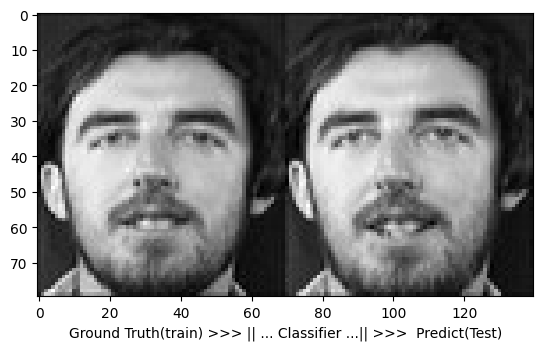

is it correct ? True


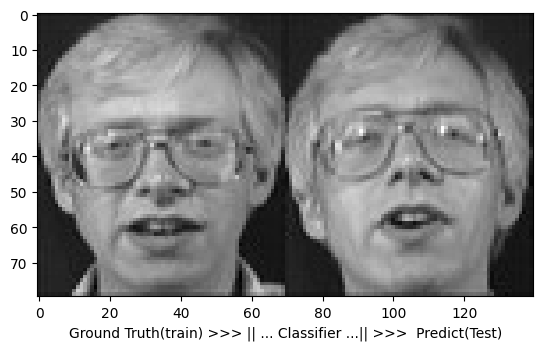

is it correct ? True


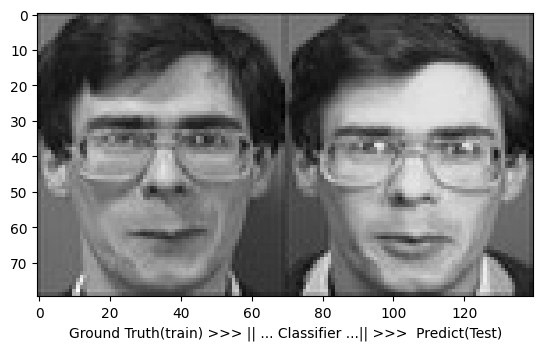

is it correct ? True


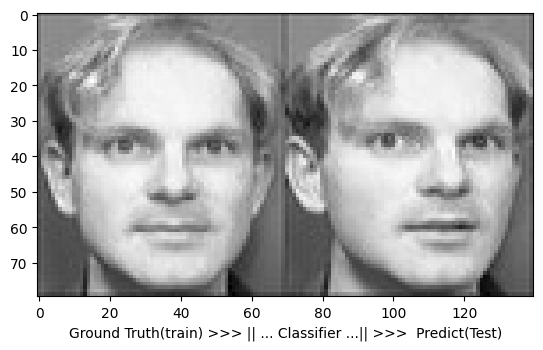

is it correct ? True


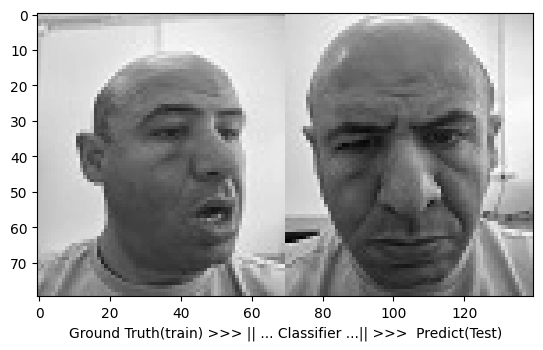

is it correct ? True


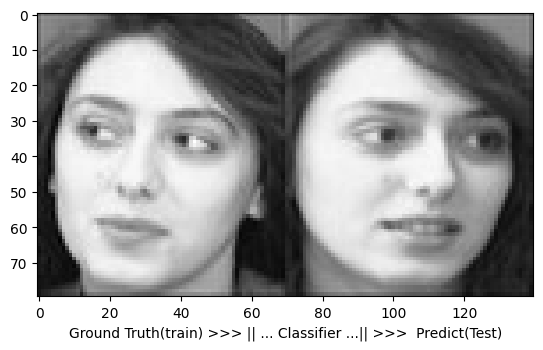

is it correct ? True


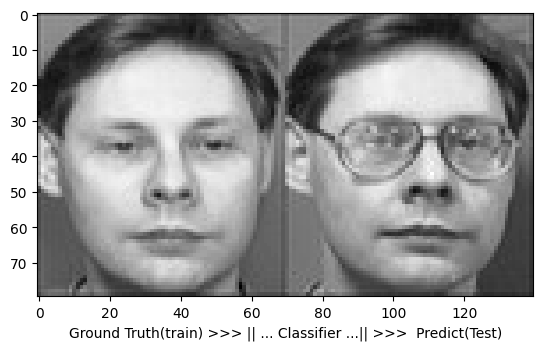

is it correct ? True


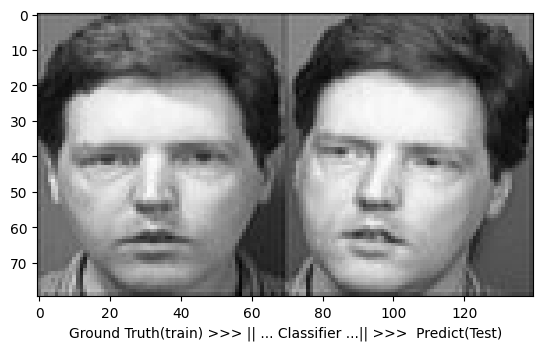

is it correct ? True


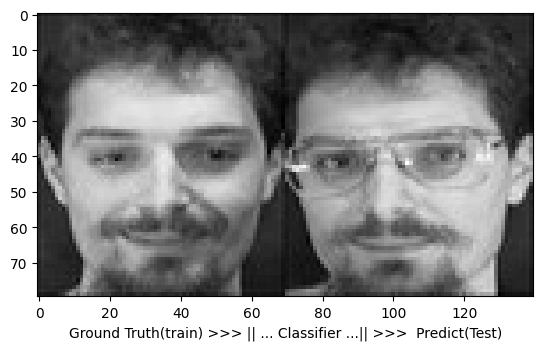

is it correct ? True


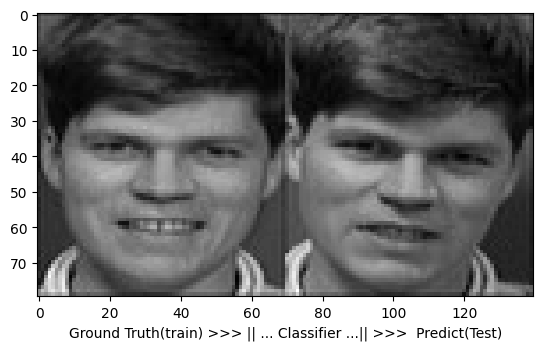

is it correct ? True


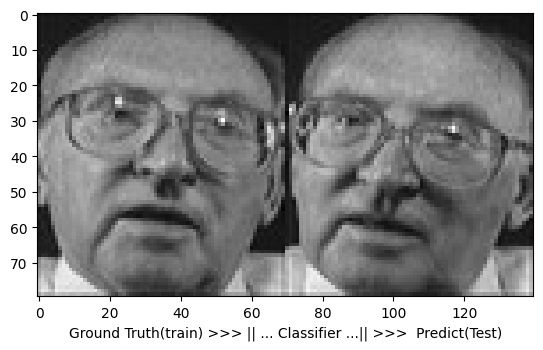

is it correct ? True


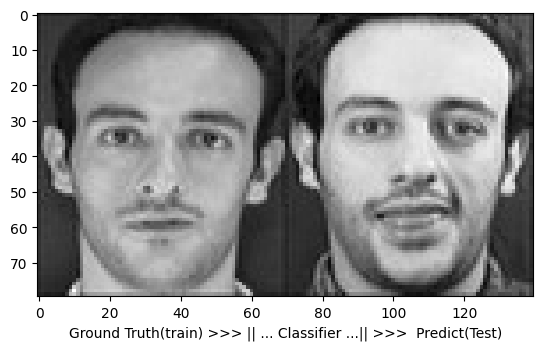

is it correct ? True


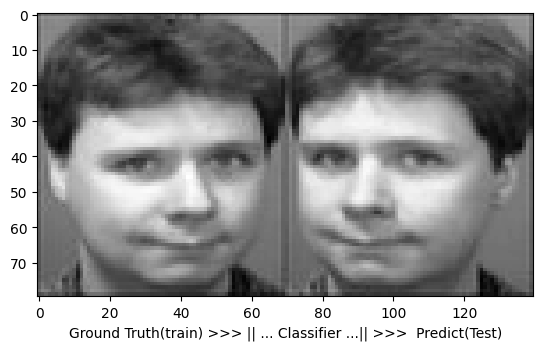

is it correct ? True


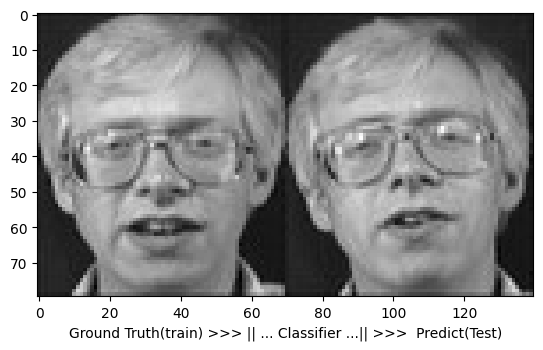

is it correct ? True


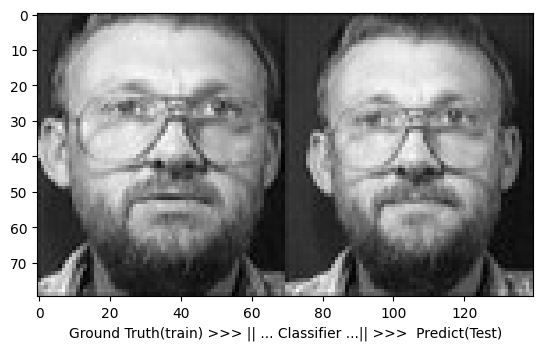

is it correct ? True


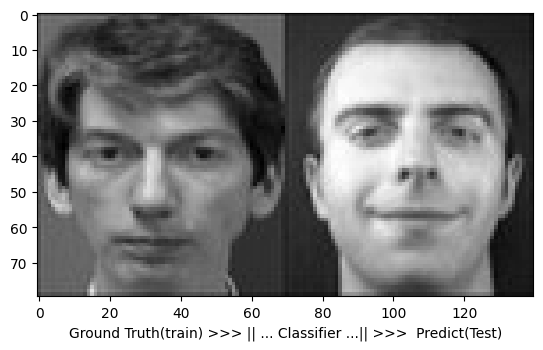

is it correct ? False


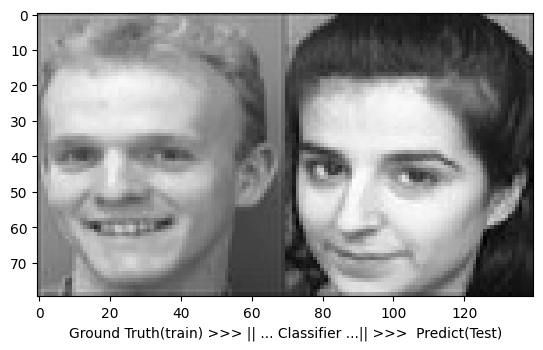

is it correct ? False


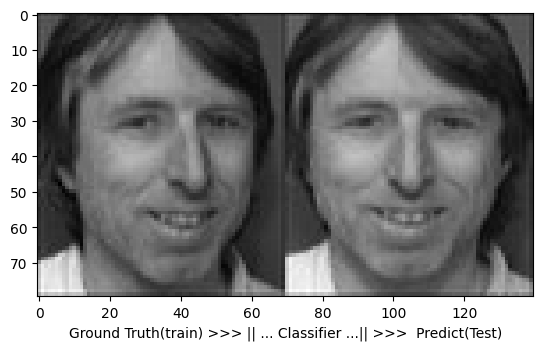

is it correct ? True


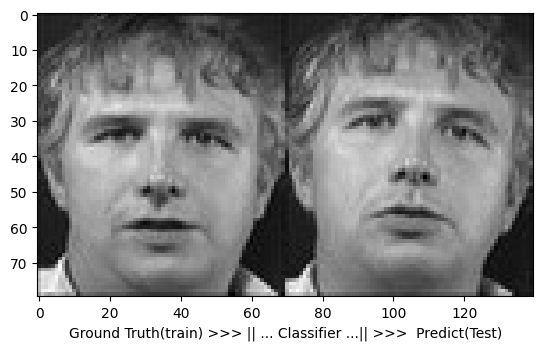

is it correct ? True


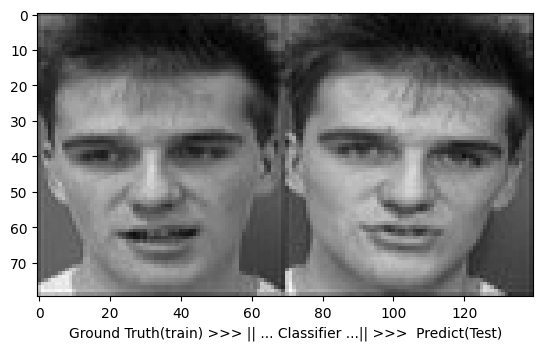

is it correct ? True


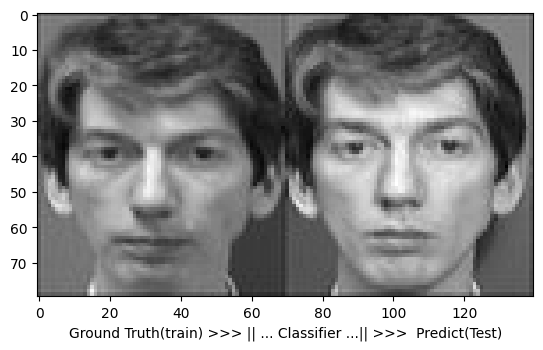

is it correct ? True


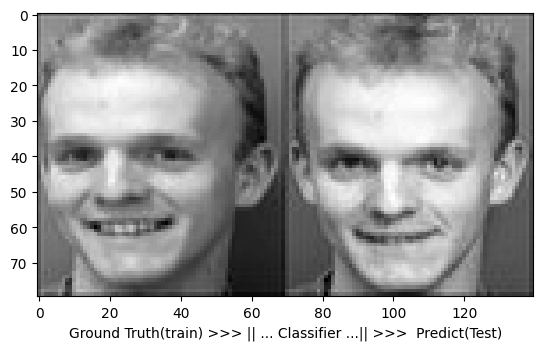

is it correct ? True


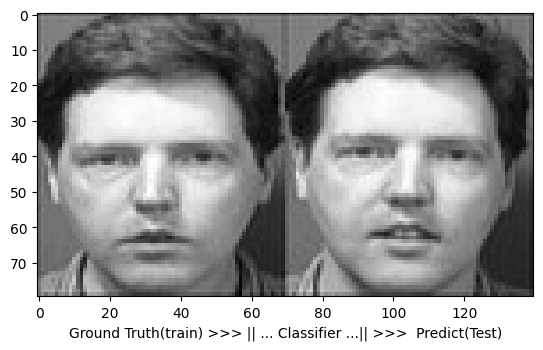

is it correct ? True


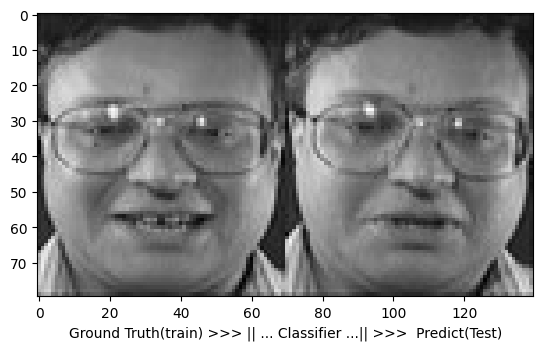

is it correct ? True


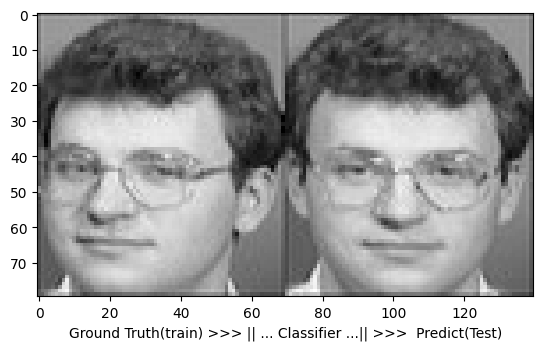

is it correct ? True


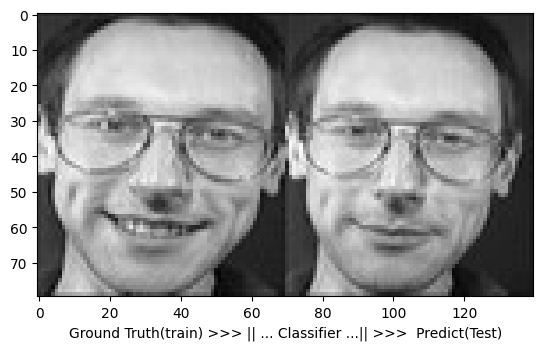

is it correct ? True


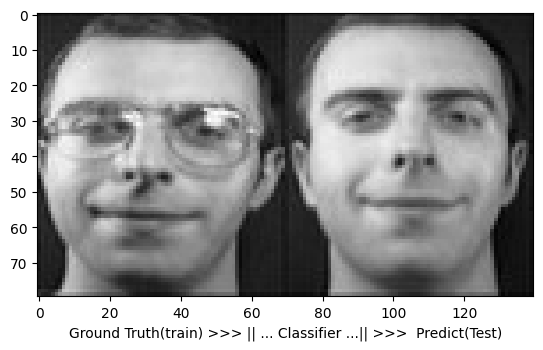

is it correct ? True


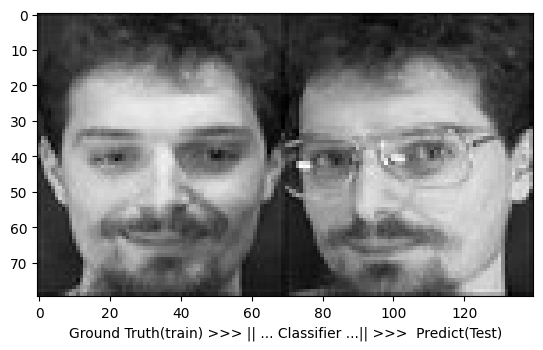

is it correct ? True


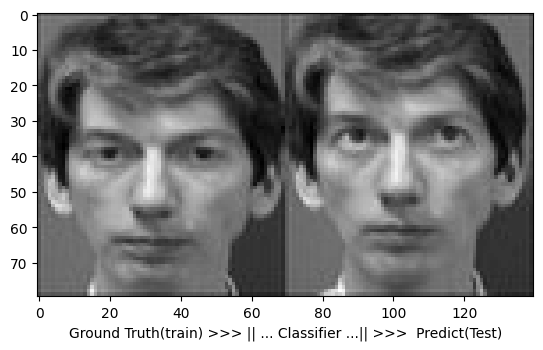

is it correct ? True


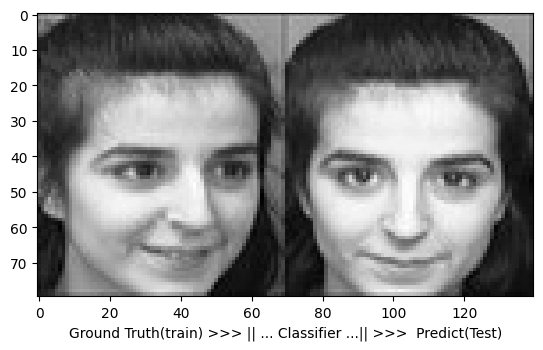

is it correct ? True


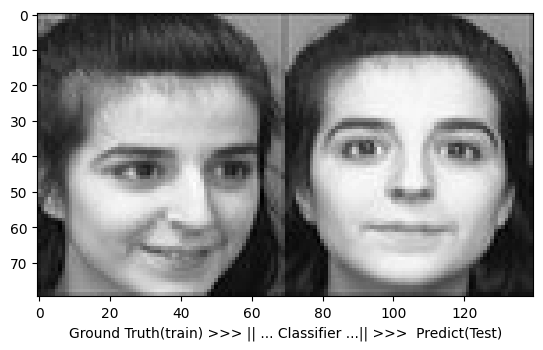

is it correct ? True


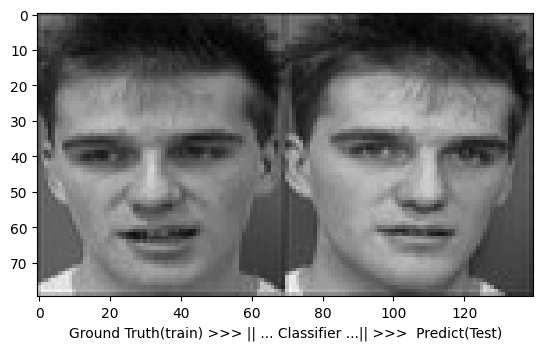

is it correct ? True


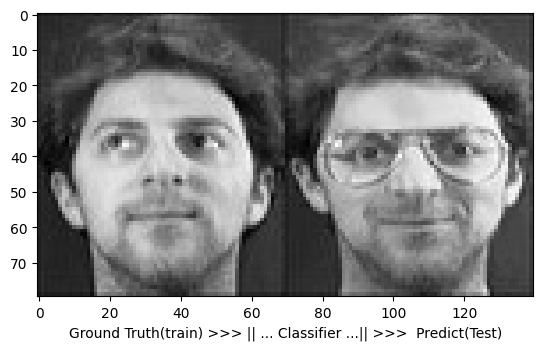

is it correct ? True


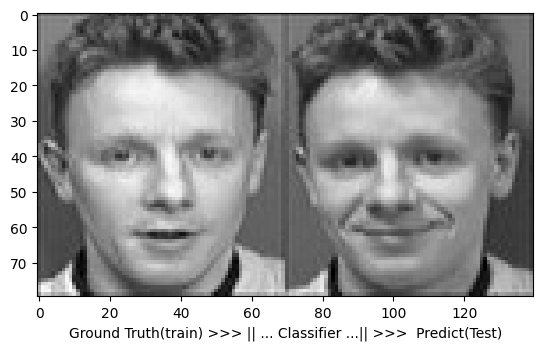

is it correct ? True


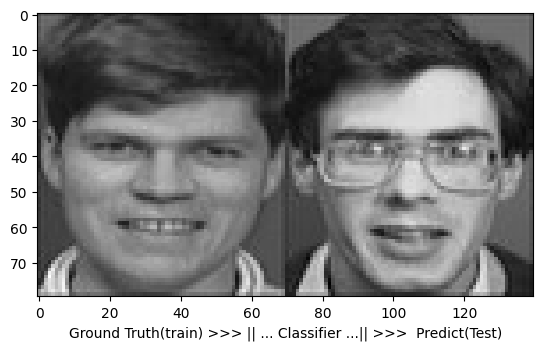

is it correct ? False


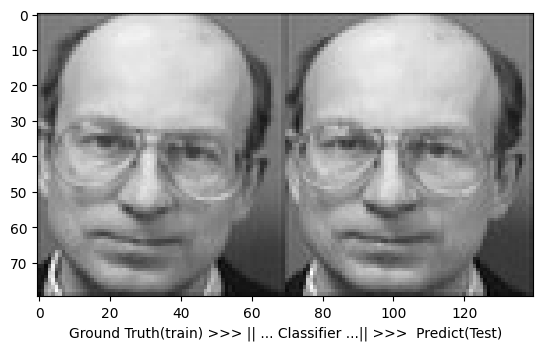

is it correct ? True


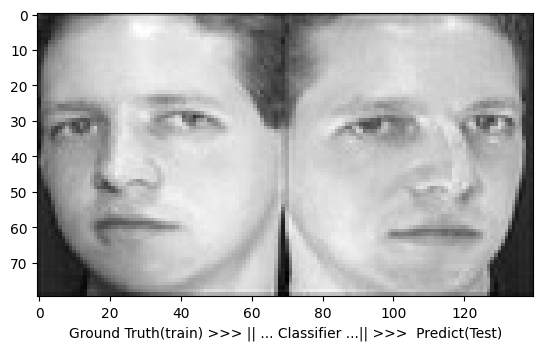

is it correct ? True


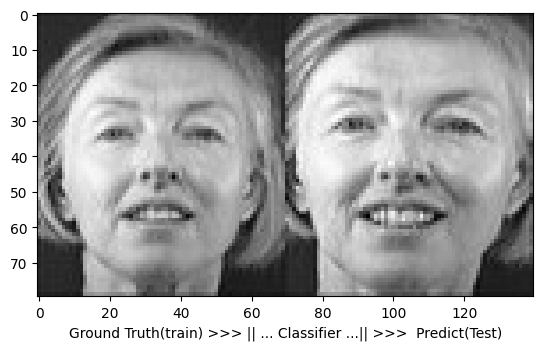

is it correct ? True


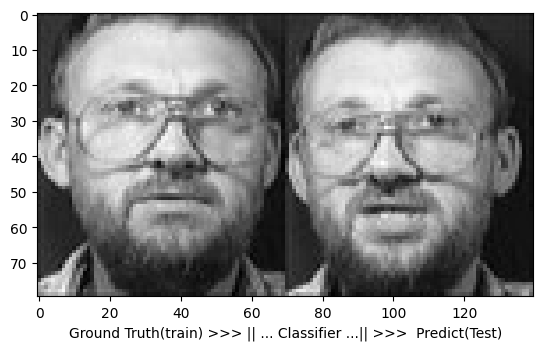

is it correct ? True


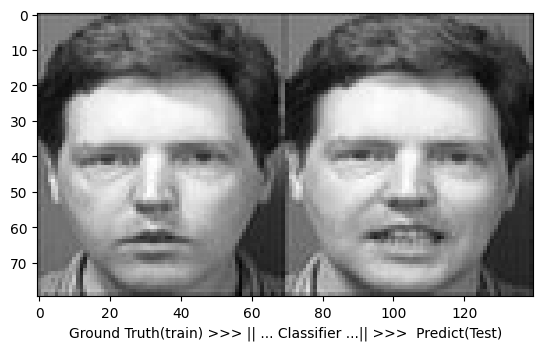

is it correct ? True


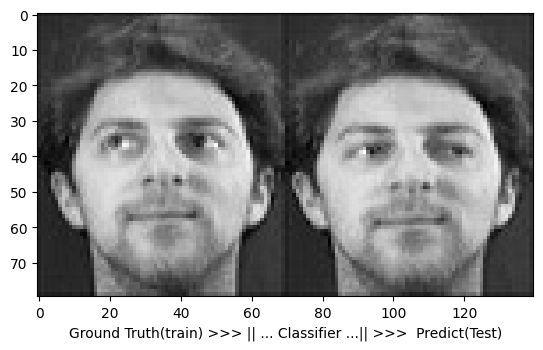

is it correct ? True


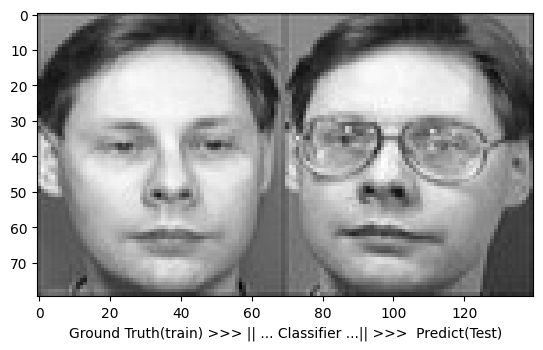

is it correct ? True


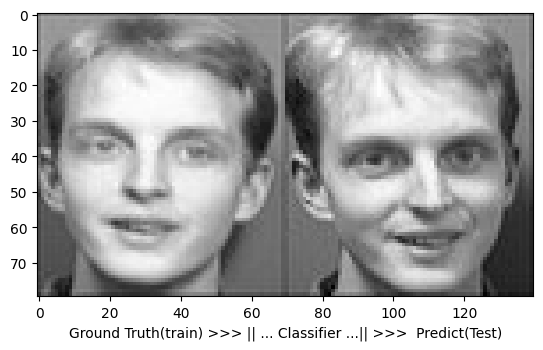

is it correct ? True


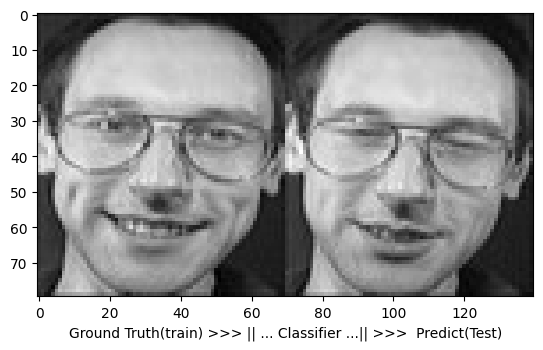

is it correct ? True


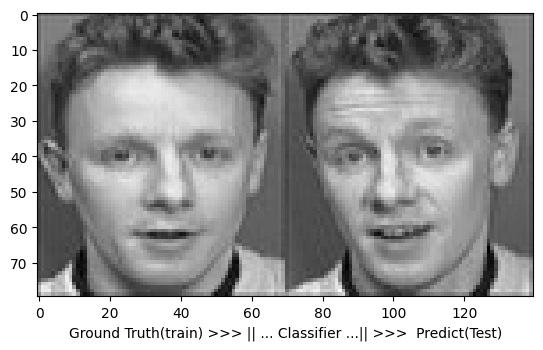

is it correct ? True


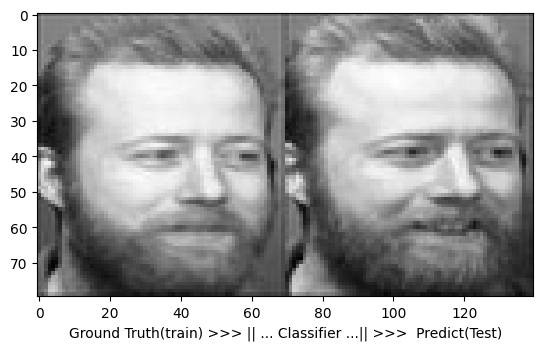

is it correct ? True


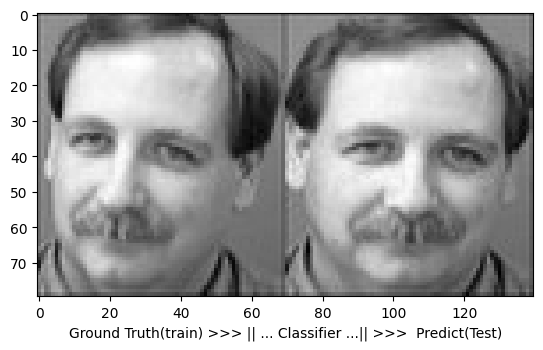

is it correct ? True


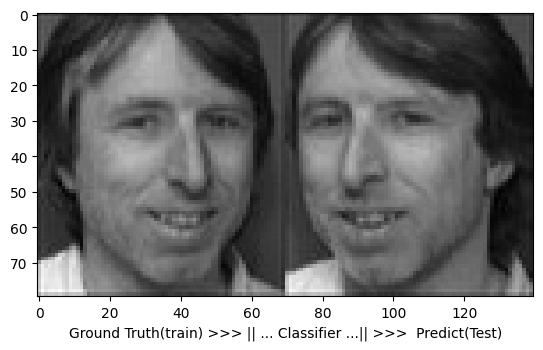

is it correct ? True


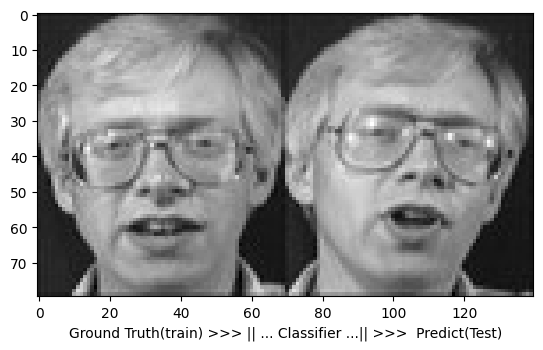

is it correct ? True


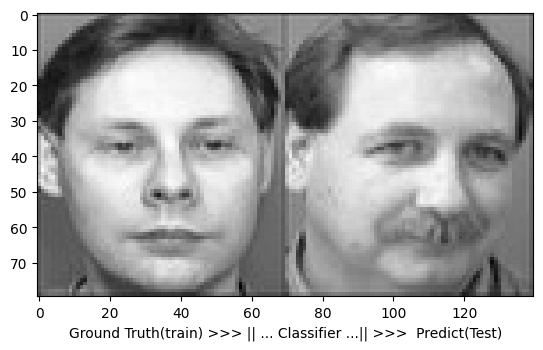

is it correct ? False


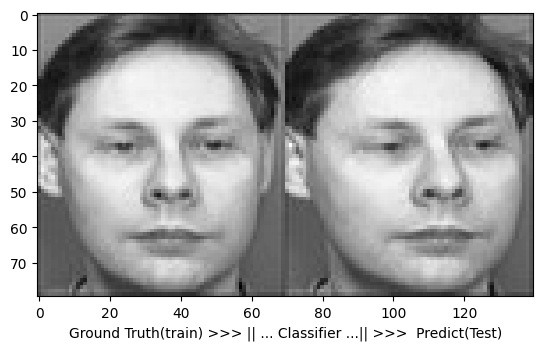

is it correct ? True


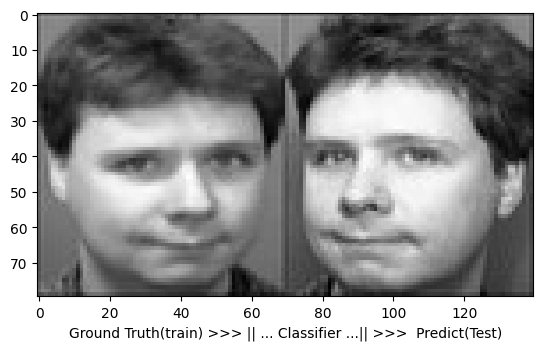

is it correct ? True


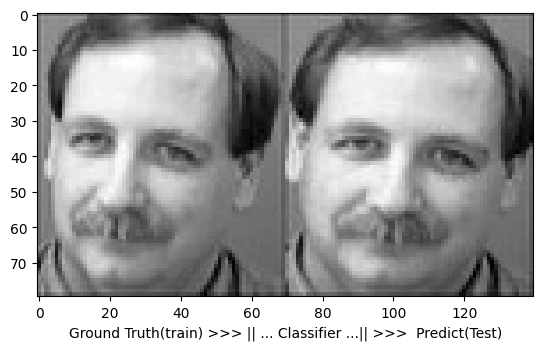

is it correct ? True


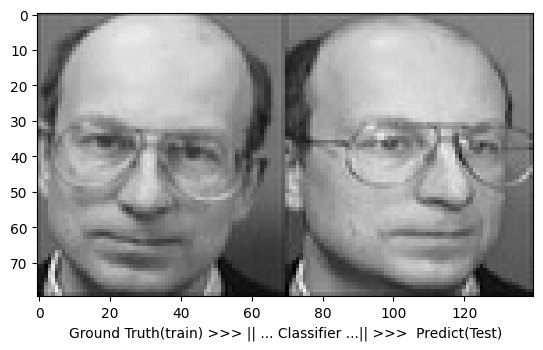

is it correct ? True


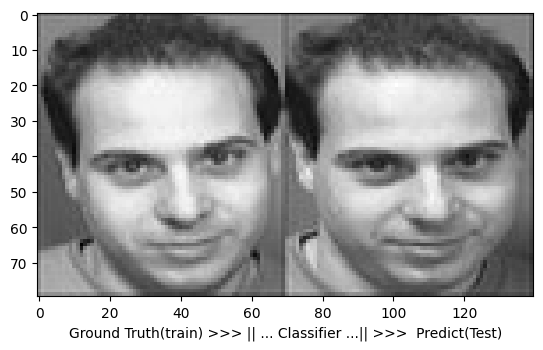

is it correct ? True


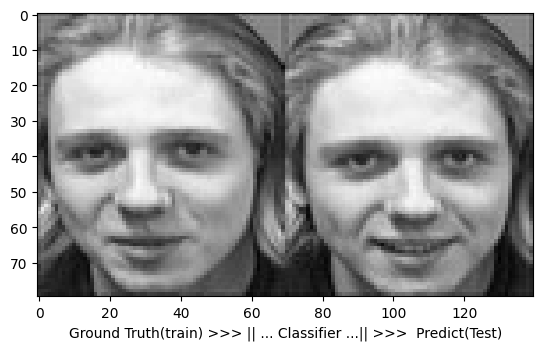

is it correct ? True


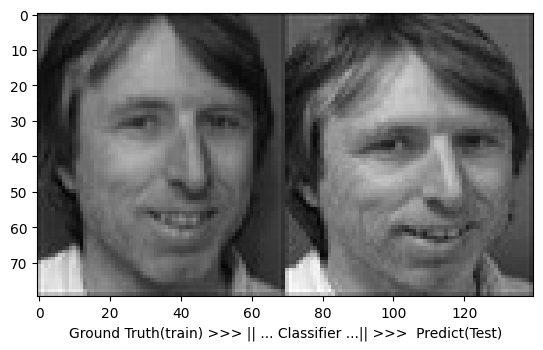

is it correct ? True


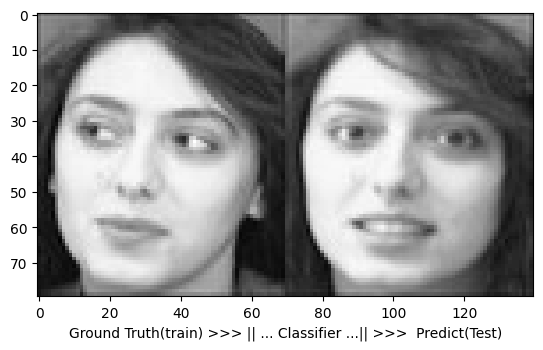

is it correct ? True


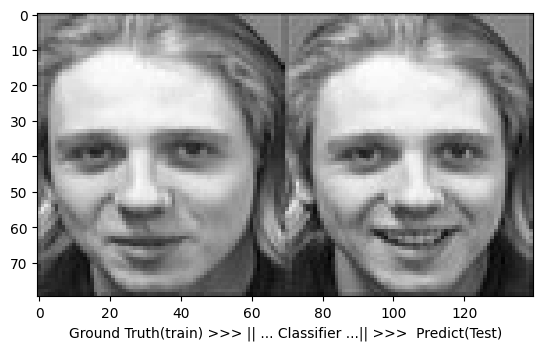

is it correct ? True


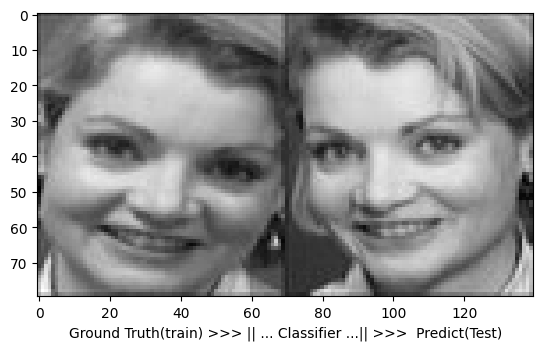

is it correct ? True


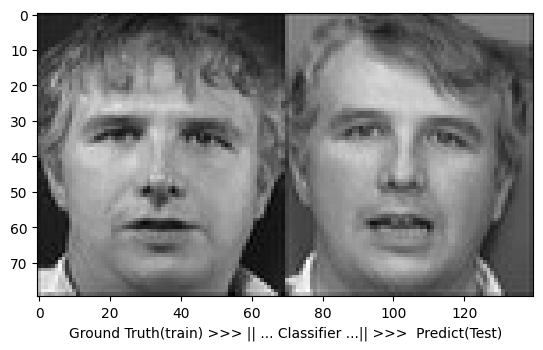

is it correct ? True


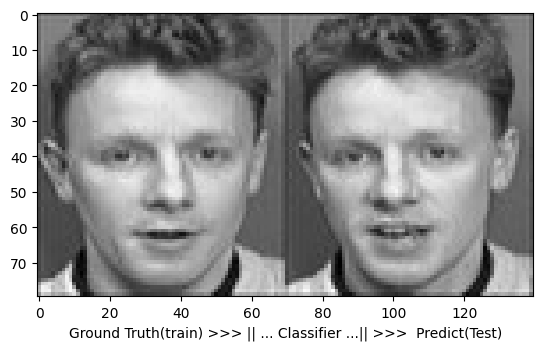

is it correct ? True


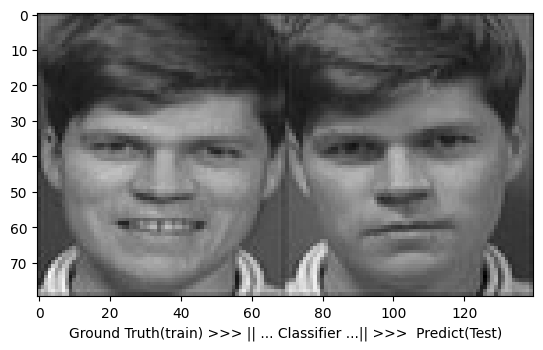

is it correct ? True


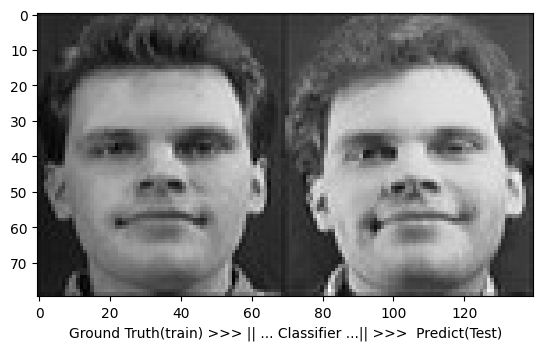

is it correct ? True


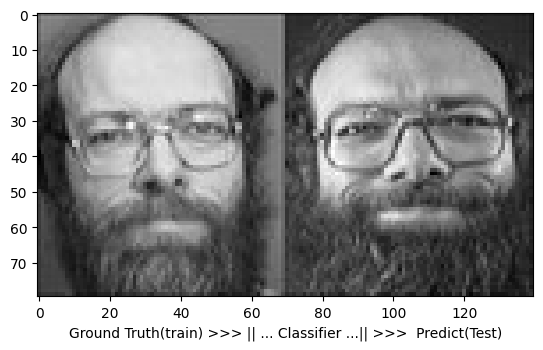

is it correct ? True


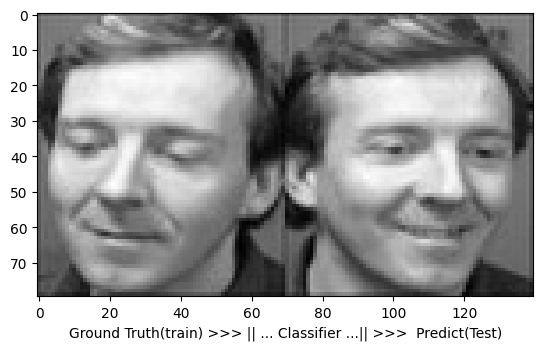

is it correct ? True


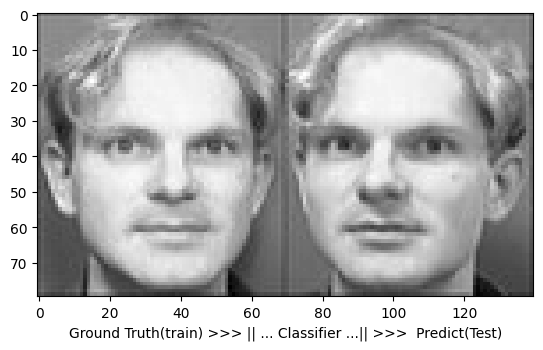

is it correct ? True


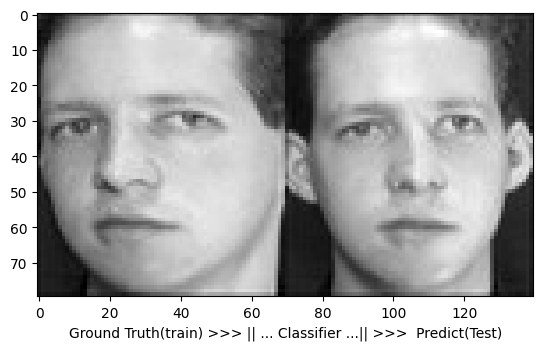

is it correct ? True


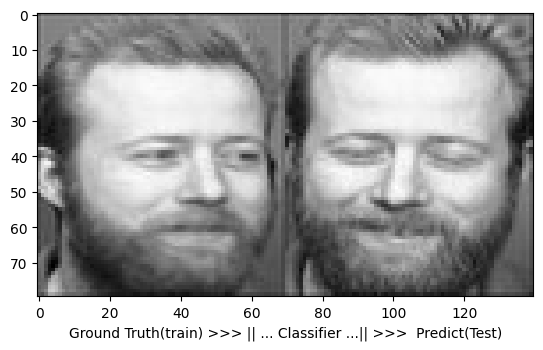

is it correct ? True


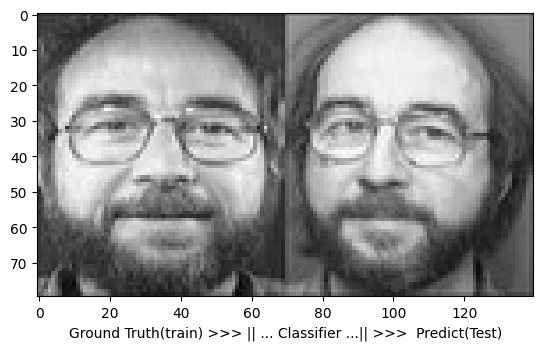

is it correct ? True


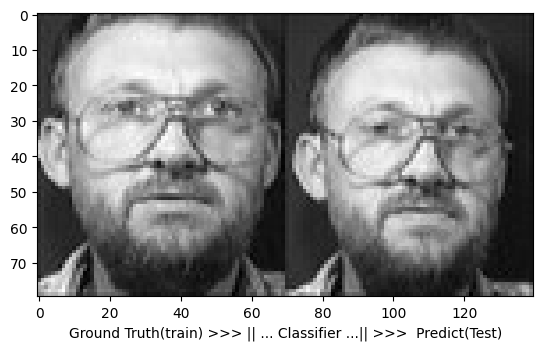

is it correct ? True


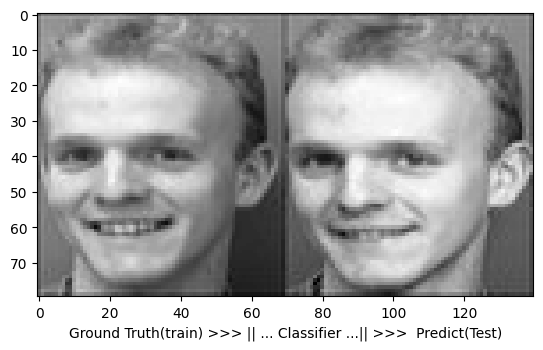

is it correct ? True


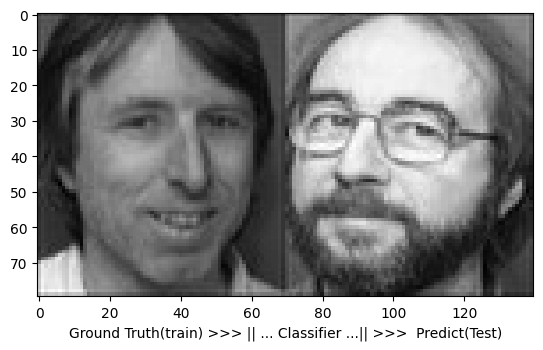

is it correct ? False


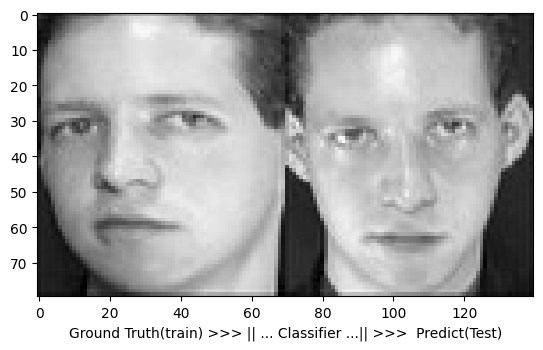

is it correct ? True


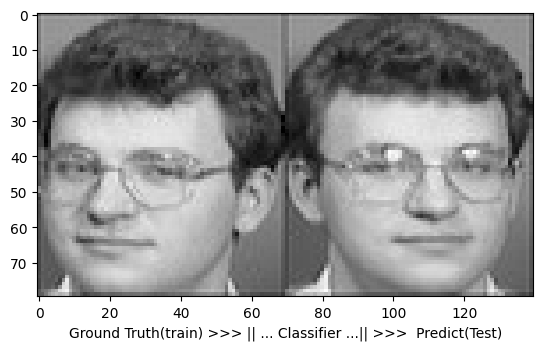

is it correct ? True


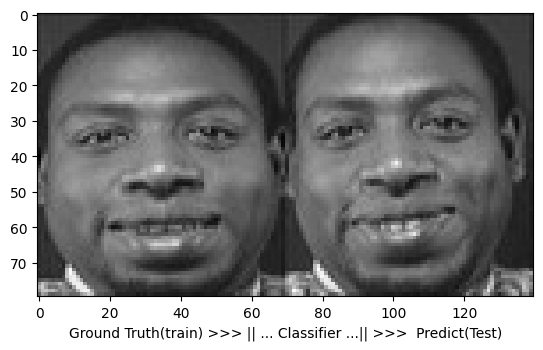

is it correct ? True


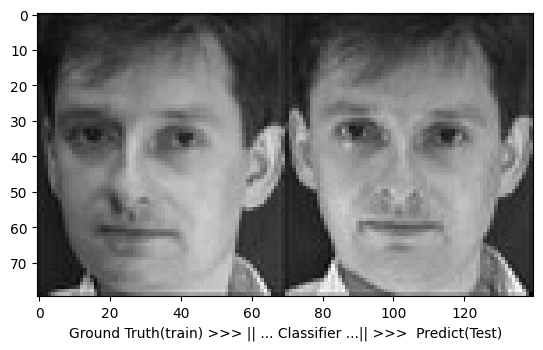

is it correct ? True


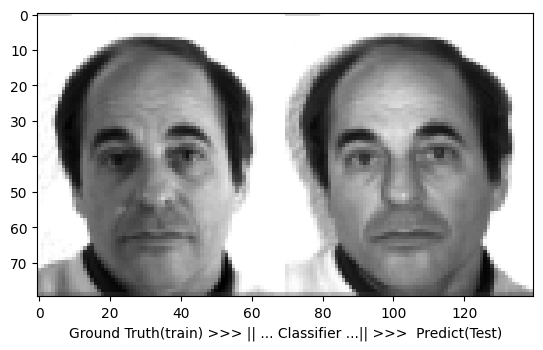

is it correct ? True


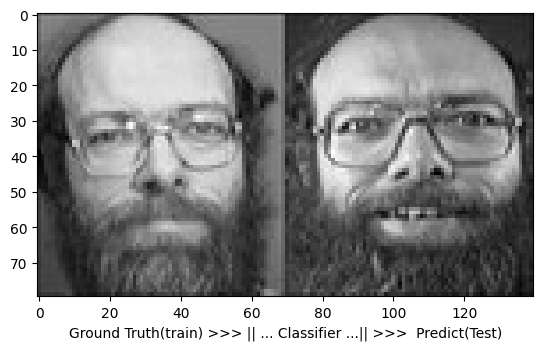

is it correct ? True


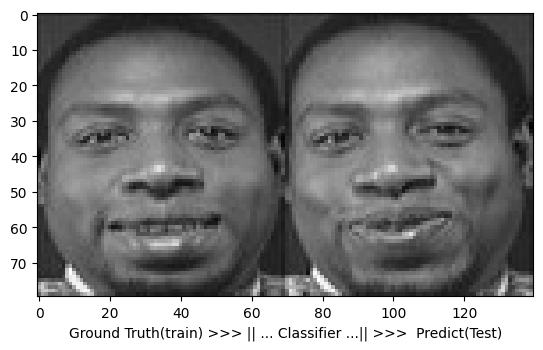

is it correct ? True


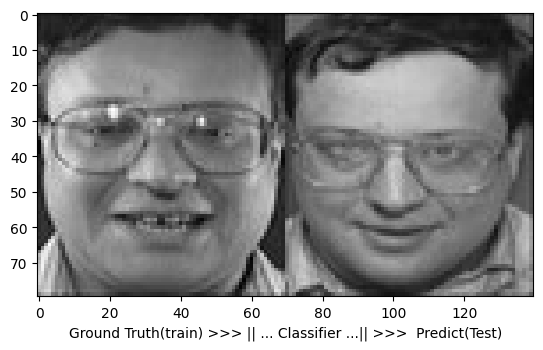

is it correct ? True


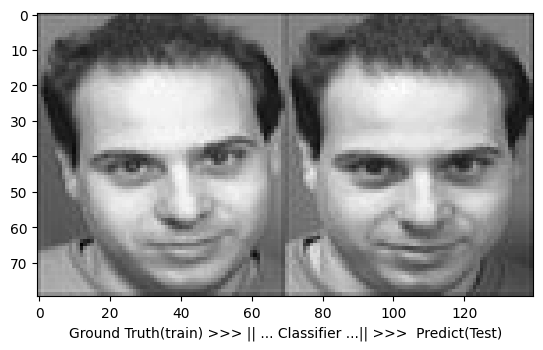

is it correct ? True


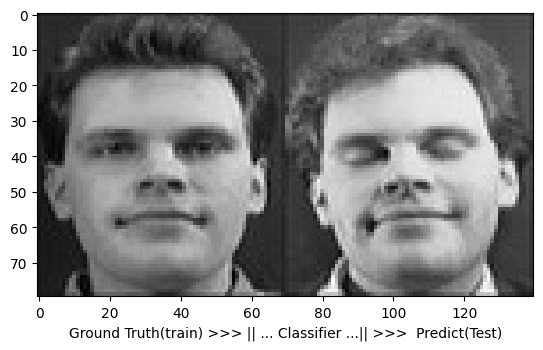

is it correct ? True


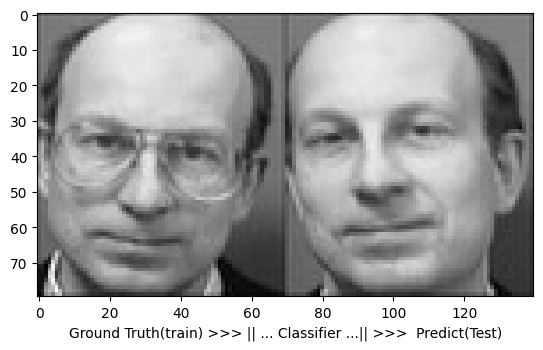

is it correct ? True


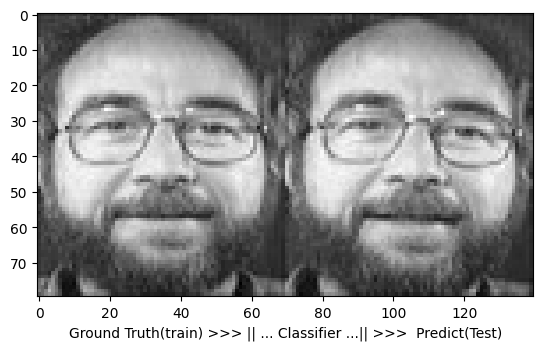

is it correct ? True


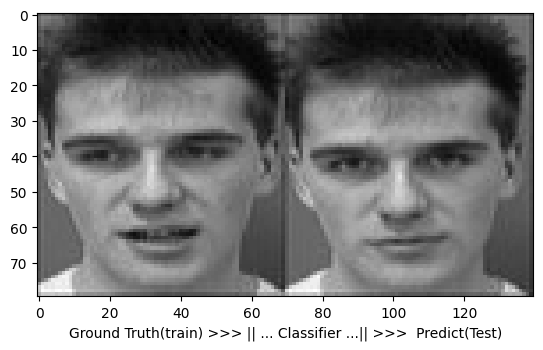

is it correct ? True


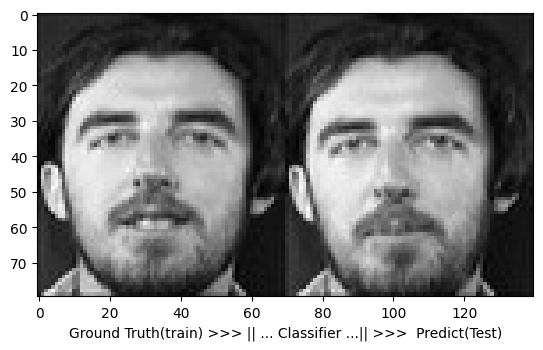

is it correct ? True


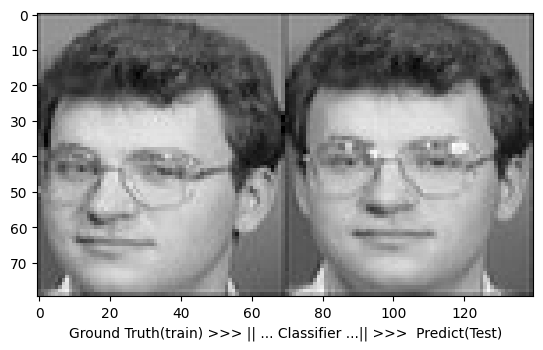

is it correct ? True


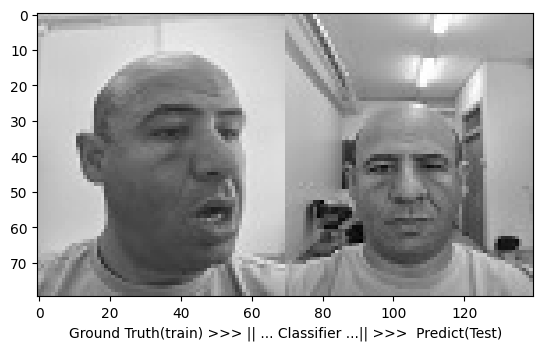

is it correct ? True


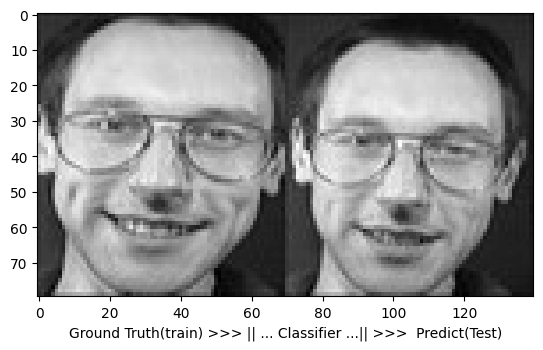

is it correct ? True


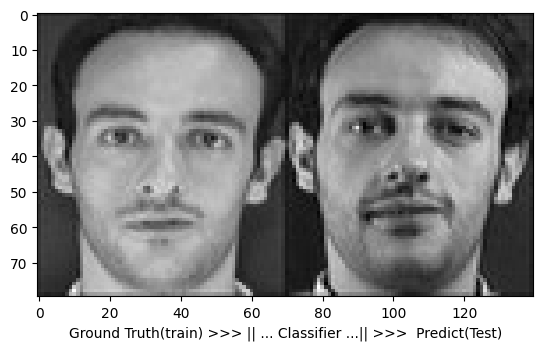

is it correct ? True


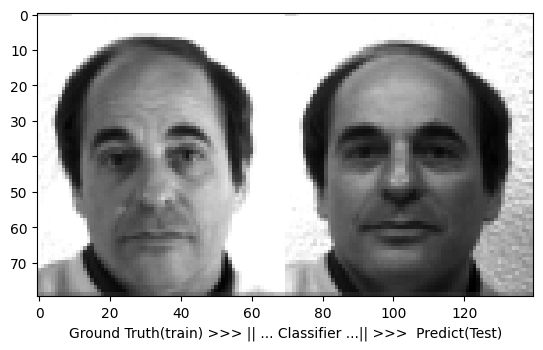

is it correct ? True


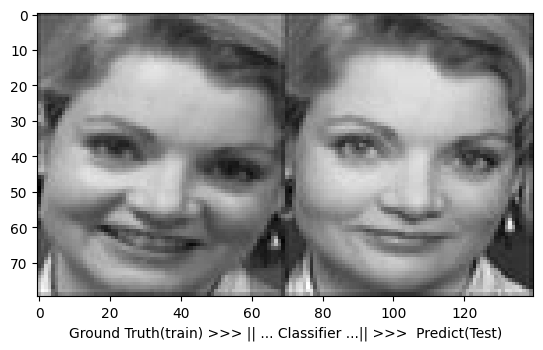

is it correct ? True


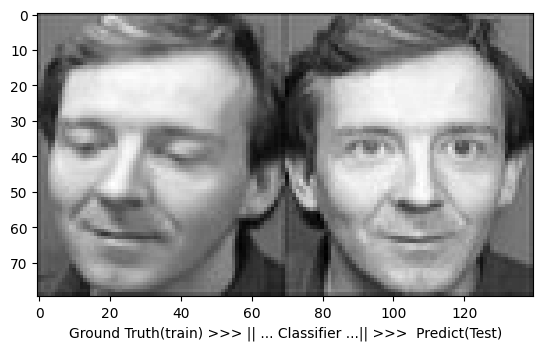

is it correct ? True


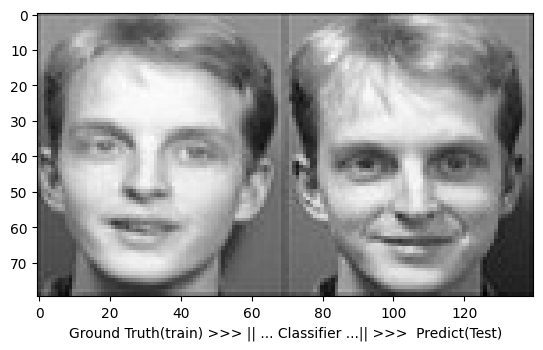

is it correct ? True


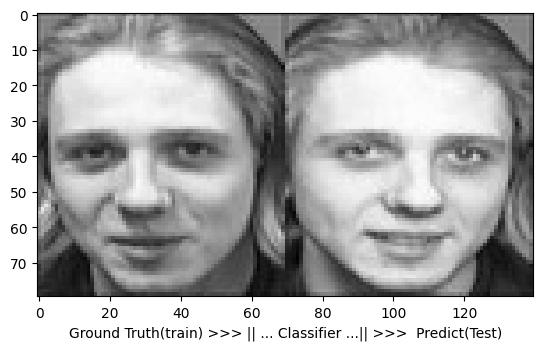

is it correct ? True


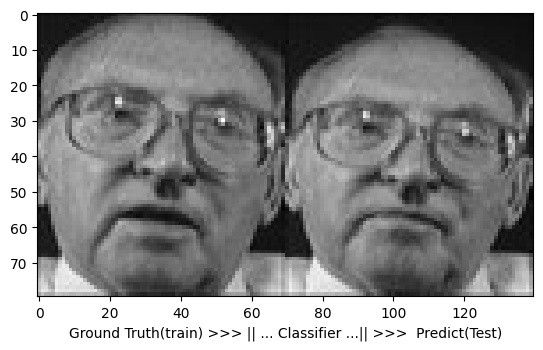

is it correct ? True


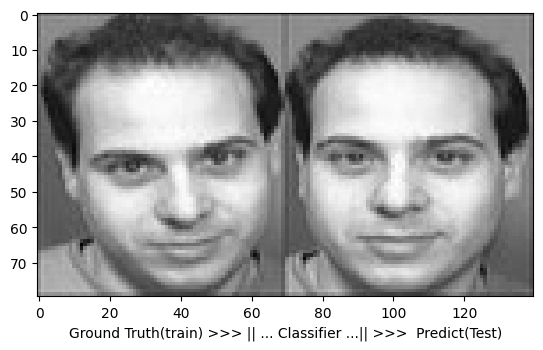

is it correct ? True


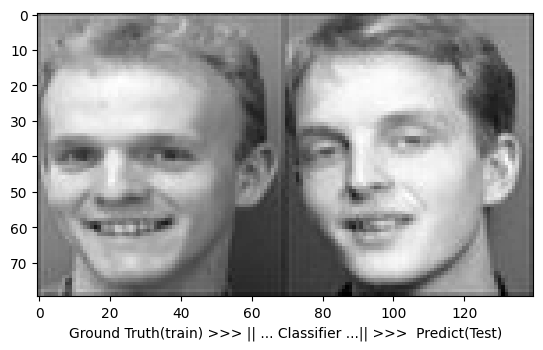

is it correct ? False


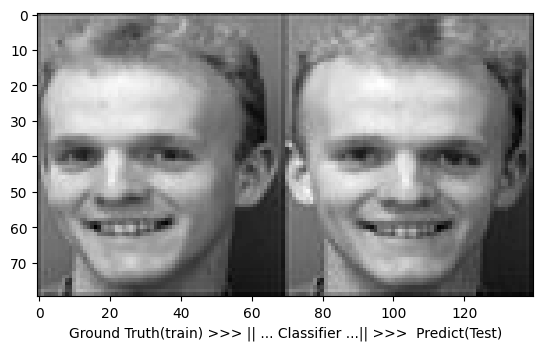

is it correct ? True


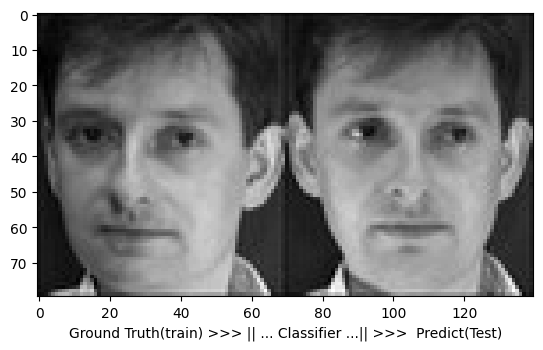

is it correct ? True


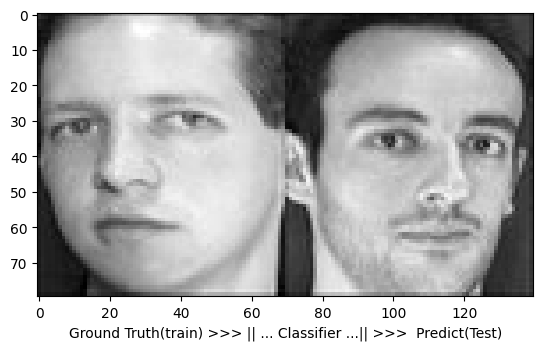

is it correct ? False


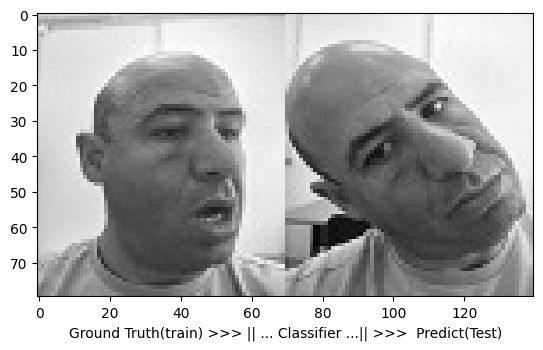

is it correct ? True


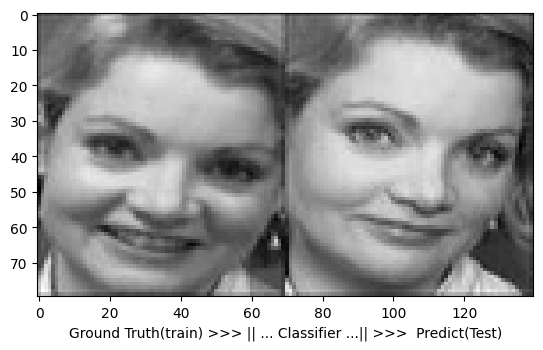

is it correct ? True


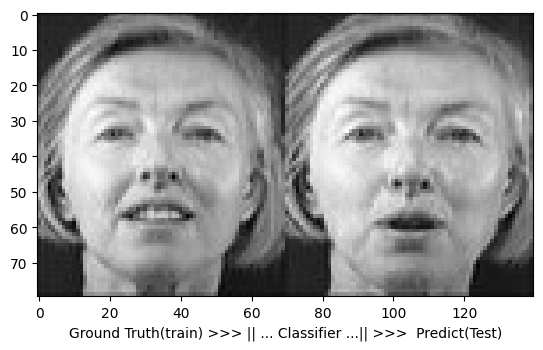

is it correct ? True
Test Size(%) >>>> 0.25 || Accuracy >>>>> 0.9333333333333333


In [25]:
#######################
#main
#######################


#To choose test size
test_size = 0.25

#To shuffle the data
X, y = shuffle(df.iloc[:,:-1], df.iloc[:,-1])

#To split data in Train and Test
X_Train, X_Test,\
y_Train, y_Test,\
indices_Train, indices_Test = train_test_split(X,
                                               y,
                                               # df.iloc[:,:-1],
                                               # df.iloc[:,-1],
                                               np.arange(df.shape[0]),
                                               test_size=test_size, stratify=y,
                                               # random_state=42
                                              )


#Train Q, B = procrustes(X, files) | Application of theory by function procrustes
Q, B = procrustes(X_Train, y_Train)


#To predict image into Test set | Application of theory by function predictprocrustes
y_result = []
for ind in list(X_Test.index):
    y_result.append(predictprocrutes(Q, B, ind))

#To check accuracy of model
y_result = pd.Series(np.asarray(y_result, dtype='int'))
print(f"Test Size(%) >>>>", test_size,"|| Accuracy >>>>>", accuracy_score(y_result, np.asarray(y_Test, dtype='int')))